## Stock Price Prediction

The stock market is a trillion-dollar industry with lots of potential for investors. Traders have made unbelievable amounts of profit by getting in on the right stock at the right time. But identifying the right time is never a straightforward event.

Imagine you want to make money trading stocks, and you only want to buy stocks you can trade for higher. As a day trader, you want to only buy a stock at the start of trade each day only if you're certain the price will increase before close of day. How can you be sure there'll be a price increase?

That is the question this project seeks to answer. How can you know for certain that the price of a stock will increase tomorrow, so you can plan to buy it at the start of trade tomorrow?

A classification algorithm will be built to answer this question. The algorithm's goal will be to predict if the price will go up (not by how much it went up). A deicison to buy a stock will then be based on whether the price is predicted to go up or not.

Although you may not be able to tell just how much profit you'd be making from a trade, this algorithm should help you make a profit on every trade. 

### The Data

The yfinance API is third-party API that draws daily stock price data from the Yahoo Finance platform, and has a record for the entire historical price data of most stocks. This is where the data for this project will come from. First, we'll download the data. Then, we'll explore it and set it up for our machine learning model. 

For this specific project, we'll be working with the Microsoft (MSFT) stock price data from when it began trading to present. Once the data is downloaded, it'll be saved locally to keep us from calling the API every time we need it.

In [1]:
# Installing relevant packages

import yfinance as yf
import pandas as pd
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# The data file will be read from the API and saved locally for easy access in the future

DATA = "msft_data.json"

if os.path.exists(DATA):
    # If the data already exists locally, read the stored data
    with open(DATA) as f:
        msft_data = pd.read_json(DATA)
else:
    # If the file doesn't already exist, download it from the yfinance API and save to json
    msft = yf.Ticker("MSFT")
    msft_data = msft.history(period="max")
    msft_data.to_json(DATA)

### Data Exploration

In [3]:
# Display the microsoft stock price history
msft_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


In [4]:
msft_data.shape

(9049, 7)

From the above, we make some important findings. First, each row of data stands for a day of trading. This means a row is tied to every trading day (stocks don't trade on weekends) since the stock was listed. There are 5 important columns in this data:

+ Open - The price the stock opened trading at
+ High - The highest price the stock got to during trading hours that day
+ Low - The lowest price the stock got to during trading hours that day
+ Close - The closing stock price for the day
+ Volume - The number of shares traded that day

Next, we'll plot the data to visualize how the stock price has changed over time. This will be done using just the closing price of every trading day.

<AxesSubplot:>

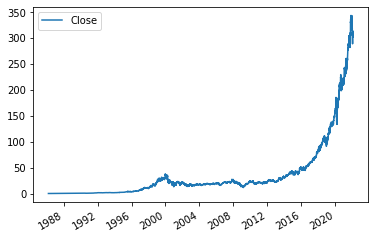

In [5]:
# Visualizing the microsoft stock price changes

msft_data.plot.line(y="Close", use_index=True)

<AxesSubplot:>

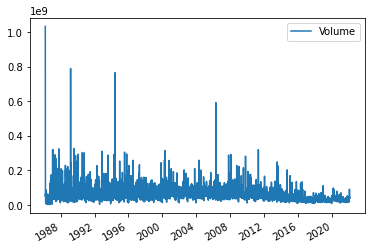

In [6]:
msft_data.plot.line(y="Volume", use_index=True)

The above tells us the Microsoft price has been on a steady upward trajectory for the last 30 years. Also interesting is the clear lack of relationship between trading volume and the microsoft stock prices. 

### Data Preparation

The goal of this exercise is to make binary predictions about the price of the microsoft stock. This means we should be able to tell whether the price of the stock goes up tomorrow, using today's data.

To begin, we need to determine the days during which the prices went up or down. Then, we need to create a target variable which will be `1` for days when the prices went up, and `0` for days when the price dropped.

Finally, we'll shift the data "forward" by one day, so it can be used to predict the target price. The idea is that the data from the previous day will be used for the prediction of each day's target variable. Shifting the data forward will keep us from predicting today's target using today's data.

#### Setting up the training dataset

This will be done in two steps:

+ First, we'd copy the existing `close` values into a new dataset. This data column will be renamed `Actual Close` to ensure it is retained after shifting the data forward by one day. 

+ Next, we'll use the pandas `rolling` method to compare every row of data with the row before it. This method picks each pair of rows. We will be returning 1 for everytime the day's close value is greater than the one before it.

+ Next, we'll use the pandas `shift` method to shift the values forward by one row. This method will, for instance, move the values from the trading day `1986-03-13` to `1986-03-14`, thus ensuring we're making predictions the future from the past. This will be done in a new dataset for organization purposes

+ Finally, we'll combine both datasets using the `join` method. We will also be dropping the first trading day data as there are no available values for prediction using our model

In [7]:
# Select and store the Close column to a new dataframe
data = msft_data[["Close"]]

# Rename the column to 'actual_close' so it doesn't get mixed up
data = data.rename(columns={'Close': "Actual_Close"})

In [8]:
# Create the target variable using the rolling method
data["Target"] = msft_data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])['Close']

In [9]:
data.head()

,Actual_Close,Target
1986-03-13,0.061378,NaN
1986-03-14,0.063570,1.0
1986-03-17,0.064667,1.0
1986-03-18,0.063022,0.0
1986-03-19,0.061926,0.0


In [10]:
# Shift stock prices foward by one day to ensure today's values only 
# predict tomorrow's target
msft_forward = msft_data.copy()
msft_forward = msft_forward.shift(1)

In [11]:
msft_forward.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055898,0.064119,0.055898,0.061378,1.031789e+09,0.0,0.0
1986-03-17,0.061378,0.064667,0.061378,0.063570,3.081600e+08,0.0,0.0
1986-03-18,0.063570,0.065215,0.063570,0.064667,1.331712e+08,0.0,0.0
1986-03-19,0.064667,0.065215,0.062474,0.063022,6.776640e+07,0.0,0.0


In [12]:
# Select the first 5 columns of our dataset for our predictor values
predictors = list(msft_data.columns[:-2])

# Combine the two newly created datasets for our training data
data = data.join(msft_forward[predictors]).iloc[1:]

In [13]:
data.head()

,Actual_Close,Target,Open,High,Low,Close,Volume
1986-03-14,0.063570,1.0,0.055898,0.064119,0.055898,0.061378,1.031789e+09
1986-03-17,0.064667,1.0,0.061378,0.064667,0.061378,0.063570,3.081600e+08
1986-03-18,0.063022,0.0,0.063570,0.065215,0.063570,0.064667,1.331712e+08
1986-03-19,0.061926,0.0,0.064667,0.065215,0.062474,0.063022,6.776640e+07
1986-03-20,0.060282,0.0,0.063022,0.063570,0.061378,0.061926,4.789440e+07


### Machine Learning Model Building

It's finally time to build the machine learning model. The `Random Forest Classifier` will be used for this prediction. Thanks to its ability to pickup non-linear relationships in data, this is a great model for our data type.

Because this is a time series data, we can't just split the training and testing data using sklearn's `train_test_split` module. This will split the data without regard for its sequential ordering, leading to leakage where the data from the future will be used to predict the past. For this same reason, we can't use cross validation modules for our model building.

Instead, the training and testing data will be split sequentially. We'll begin by leaving only the last 100 rows of data for our test dataset.

In [14]:
# Import relevant packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

In [15]:
# Splitting the train and test data
train = data.iloc[:-100]
test = data.iloc[-100:]

# Creating the randomforest model with large numbers of predictors
model = RandomForestClassifier(n_estimators=150, min_samples_split=200, random_state=1)

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, n_estimators=150, random_state=1)

In [16]:
# Evaluate the model performance

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
print(f"The precision score of the model is: {precision_score(test['Target'], preds)}")
print(f"The accuracy score of the model is: {accuracy_score(test['Target'], preds)}")

The precision score of the model is: 0.5882352941176471
The accuracy score of the model is: 0.48


In [17]:
# Compare the number of times we would have traded vs days trading was profitable
print(f"Following this model, we would have traded {preds.sum()} times, although trading was profitable on {test['Target'].sum()} days out of {len(test)}.")

Following this model, we would have traded 17.0 times, although trading was profitable on 55.0 days out of 100.


The result here is indicative of how poor our model is. A precision score of 52.9% indicates that the model correctly predicts the days to trade ~53% of the time. This means we miss out on more than half the days we were supposed to trade. An accuracy score of 46% means the model is generally more inaccurate than accurate. 

<AxesSubplot:>

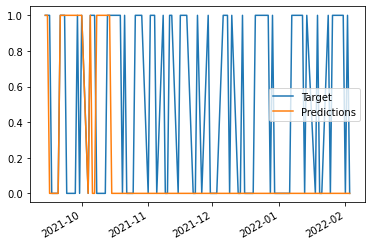

In [18]:
combined = pd.concat({"Target": test['Target'], "Predictions":preds}, axis=1)
combined.plot()

The above shows that our model was correct (accurately predicting the best times to purchase or sit back) for a few days in October of 2021. After this period, though, the model only forecasted against making a purchase. It was right just about 50% of the time.

### Improving the Model - Backtesting

Finding better parameters can help us build a much better model. Before getting into that, though, there's something else to try.

Backtesting is a way of testing how a model performs on historical data. It assesses the viability of our model by checking how it'll have performed ex-post. This means using only data from the past to predict the future in order to avoid unrealistic prediction performance.

Considering the nature of our data, we will need to write out a function to bakctest our model. The function will loop over the dataset and train a model every 750 rows. To achieve this, the function will need to:

+ Split the training and testing data
+ Train a model
+ Make predictions on the test data using the training data

In [19]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = pd.DataFrame({"Target":[], "Predictions":[]})
    # Loop over the dataset
    for i in range(start, data.shape[0], step):
        # Split the train and test data
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the model
        model.fit(train[predictors], train['Target'])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0

        # Combine predictions and test values
        prediction = pd.concat({"Target": test["Target"], "Predictions":preds}, axis=1)

        # Store all predictions and test values in a single dataframe
        frames = [predictions, prediction]
        predictions = pd.concat(frames)
        
    return predictions

In [20]:
predictions = backtest(data, model, predictors)

In [21]:
precision_score(predictions['Target'], predictions["Predictions"])

0.5007704160246533

In [22]:
predictions["Predictions"].value_counts()

0.0    7399
1.0     649
Name: Predictions, dtype: int64

In [23]:
predictions["Target"].value_counts()

1.0    4082
0.0    3966
Name: Target, dtype: int64

Our precision score has dropped slightly with the model now predicting on every cell. This is expected to some extent, considering there is more likelihood of error when predicting a large number of target values. The number of days where our model indicates we can make a trade is also very modest, an expected response to the higher prediction threshold (0.6).

To help improve the model, we'd be adding more features to our predictors.

### Improving the Model - Feature Engineering

Thanks to the backtesting function, we can now make predictions across the entire length of the dataset. To get the model to predict even better, more predictors are needed. This will involve some form of feature engineering on our part to see if they improve the model.

The added features will be rolling means to help the model evaluate current prices against recent prices. Also to be considered will be the relationship between different indicators.

#### Rolling Means

Rolling means or moving averages are means calculated over a specified period of time to indicate recent trends. For the first step, we'll be adding a simple moving average of 7 days, 90 days, and 365 days (1 year). 

Once again, I employ the pandas rolling method for this step.

In [24]:
# Generate trend data
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

# Add trend data to prediction dataset
data["weekly_mean"] = weekly_mean/data["Close"]
data["quarterly_mean"] = quarterly_mean/data["Close"]
data["annual_mean"] = annual_mean/data["Close"]

Next, we'll calculate the ratios between the different rolling means and add them to the dataset. This would help the algorithm understand what the weekly/quarterly trend is relative to the annual trend.

In [25]:
# Calculate annual means for each category above
data["annual_weekly_mean"] = data["annual_mean"]/data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"]/data["quarterly_mean"]

#### Weekly Trend

Next, we want our algorithm to know how many times the price has gone up over the last week. To do this, we'd combine the shift and rolling methods of the pandas library. Note the following:

+ Shifting one day forward keeps the algorithm from knowing the target value of the current day, and from incorporating this into its prediction.
+ The value of the 7-day rolling sum of the target will be a 7 if the price went up everyday of the last week, or 0 if it didn't go up at all.

In [26]:
# Generate and add the weekly trend data to the dataset

weekly_trend = data.shift(1).rolling(7).sum()["Target"]
data["weekly_trend"] = weekly_trend

#### Indicator Ratios

Indicator ratios help us understand what the price trend was like the previous day. For instance, if the highest price was much higher than the close price, it may suggest the price was on a downward trend before the close of trading. We'll generate these ratios for the open, low, and high prices, versus the close price.

In [27]:
# Calculate the ratios between different indicators
data["open_close_ratio"] = data["Open"]/data["Close"]
data["high_close_ratio"] = data["High"]/data["Close"]
data["low_close_ratio"] = data["Low"]/data["Close"]

In [28]:
data.head()

,Actual_Close,Target,Open,High,Low,Close,Volume,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
1986-03-14,0.063570,1.0,0.055898,0.064119,0.055898,0.061378,1.031789e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.910720,1.044650,0.910720
1986-03-17,0.064667,1.0,0.061378,0.064667,0.061378,0.063570,3.081600e+08,NaN,NaN,NaN,NaN,NaN,NaN,0.965519,1.017250,0.965519
1986-03-18,0.063022,0.0,0.063570,0.065215,0.063570,0.064667,1.331712e+08,NaN,NaN,NaN,NaN,NaN,NaN,0.983042,1.008474,0.983042
1986-03-19,0.061926,0.0,0.064667,0.065215,0.062474,0.063022,6.776640e+07,NaN,NaN,NaN,NaN,NaN,NaN,1.026095,1.034791,0.991305
1986-03-20,0.060282,0.0,0.063022,0.063570,0.061378,0.061926,4.789440e+07,NaN,NaN,NaN,NaN,NaN,NaN,1.017698,1.026547,0.991151


#### Updating Predictions

Finally, we've arrived at the point where we can now update our predictions and see how our new features have performed. First, we'll be creating a new list to account for the new predictors. Then, we'll cut off the first 365 days from our data while building the model. This is important as our rolling means have created `NaN` values up to that point, which will break our algorithm if let through.

In [29]:
# Update the predictors ahead of new round of testing

new_predictors = ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", 
                    "annual_quarterly_mean", "weekly_trend", "open_close_ratio", 
                    "high_close_ratio", "low_close_ratio"]

all_predictors = predictors + new_predictors

In [30]:
predictions = backtest(data.iloc[365:], model, all_predictors)

In [31]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5463258785942492

In [32]:
predictions["Predictions"].value_counts()

0.0    7370
1.0     313
Name: Predictions, dtype: int64

<AxesSubplot:>

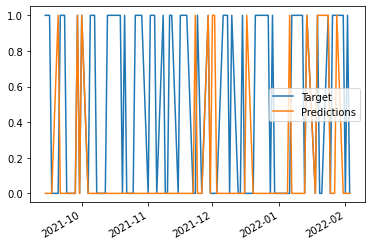

In [33]:
predictions.iloc[-100:].plot()

The precision score of the model has again improved slightly. However, once again, we've seen the number of days where we're instructed to trade drop by half. To improve the precision accuracy of the model even more, we'd need to add even more features. Then, we could test out other algorithms to see how they perform on our dataset.

In [ ]:


# Add trend data to existing dataset
data["weekly_daily_ratio"] = weekly_mean/data["Close"]
data["quarterly_daily_ratio"] = quarterly_mean/data["Close"]
data["annual_daily_ratio"] = annual_mean/data["Close"]



